# Mapping America's Police Departments, Pt. 2
This is the second entry in (what will hopefully be) an ongoing series of posts on the scope of policing in the USA. [The first entry](https://afriedman412.github.io/Mapping-the-Police-v1.0/) explained my motivation for this research, and made pretty basic national survey of America's police departments using data scraped from the website [PoliceOne](http://www.policeone.com).

The data on P1 is self-reported, incomplete, and unverified, and limited the utility of the first pass. I knew for whatever next step I took, I would have to dig for more accurate information. So I decided to limit my search to Allegheny County, Pennsylvania, which includes Pittsburgh.

In [228]:
# imports
import pandas as pd
import geopandas as gpd
import numpy as np
import statsmodels.api as sm

import pysal

from bs4 import BeautifulSoup
import re
import requests
import unidecode
import string
import datetime
import time
from IPython.display import clear_output
import urllib3
import certifi

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# Gathering the data
The shapefiles for the municipalities in Allegheny County were all available from the [Western Pennsylvania Regional Data Center](https://data.wprdc.org/dataset/allegheny-county-municipal-boundaries).

In [229]:
# import shapefiles using Geopandas
ag = gpd.read_file('Allegheny_County_Municipal_Boundaries')

# dropping extra columns
ag = ag.drop(['OBJECTID','COG', 'SCHOOLD', 'CONGDIST', 'FIPS', 'REGION', 'ACRES', 'SQMI', 'MUNICODE', 'CNTL_ID', 'CNTYCOUNCI','EOC', 'ASSESSORTE', 'VALUATIONA', 'YEARCONVER', 'GlobalID'], axis=1)

# data cleaning
ag['TYPE'] = ag['TYPE'].map(lambda x: x.lower() if x in ['CITY', 'BOROUGH', 'TOWNSHIP'] else 'municipality')
ag['LABEL'] = ag['LABEL'].map(lambda x: x.lower())

I was able to acquire 2017 population estimates from the [Census Bureau](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml).

In [230]:
# import pop data
pop = pd.read_csv('PEP_2017_PEPANNRES/PEP_2017_PEPANNRES_with_ann.csv')

# rename
pop = pop[['GEO.display-label', 'respop72017']].rename(columns={'GEO.display-label':'name', 'respop72017':'pop 2017'})

# filter by ag county
pop = pop[pop['name'].str.contains('Allegheny County')]

# clean 'name' column
pop['name'] = pop['name'].map(lambda x: x.replace(', Allegheny County, Pennsylvania', '').lower())
pop['name'] = pop['name'].map(lambda x: x.replace(' city', ''))

# spot editing
pop['name'] = pop['name'].map(lambda x: x.replace('o\'hara', 'o hara'))
pop['name'] = pop['name'].map(lambda x: x.replace('lebanon township', 'lebanon'))
pop['name'] = pop['name'].map(lambda x: x.replace('clair township', 'clair municipality'))
pop['name'] = pop['name'].map(lambda x: x.replace('hills township', 'hills municipality'))

Both datasets needed minor cleaning before merging.

In [231]:
ag_pop = pd.merge(ag, pop, how='left', left_on='LABEL', right_on='name').drop('name', axis=1)

The [Allegheny County website](http://www.alleghenycounty.us/emergency-services/police-departments.aspx) has a decent directory of its police departments and their jurisdictions.

However, I had to manually sift through local websites and old newspaper articles to dig up numbers on how many officers each department employed. PoliceOne was a good start, but still was lacking data for dozens of the departments on the county list.

These numbers are still incomplete (missing about 8 of the 130 departments listed), and I wouldn't vouch for the total accuracy of the officer counts. But I'm confident they are reasonable ballpark estimates.

In [234]:
# import data
pd_manual = pd.read_csv('ag_police_manually.csv')

# subset columns
pd_manual = pd_manual.iloc[:,0:4]
pd_manual.rename(columns={
    'total or undetermined (including sgt/chief)':'officers'}, inplace=True)

# combine name columns
pd_manual['full name'] = pd_manual['name'] + ' ' + pd_manual['muni type']

# spot fixes
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace('o\'hara', 'o hara'))
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace('lebanon township', 'lebanon'))
pd_manual['full name'] = pd_manual['full name'].map(lambda x: x.replace(' city', ''))

# adjust 'officers' column
pd_manual['officers'] = pd_manual['officers'].map(lambda x: np.NaN if x in ['NA','no data'] else x)
pd_manual['officers'] = pd.to_numeric(pd_manual['officers'])

(Again, the data needed minor adjustments before merging.)

In [235]:
ag_pop_pd = pd.merge(
    ag_pop, pd_manual, how='left', left_on='LABEL', right_on='full name').drop(
    ['NAME','TYPE','full name', 'name','muni type'], axis=1)

Since some departments cover multiple municipalities, I have adjust the data to index by police department ('agency' in the data).

The first step is to sum the populations covered by each agency (in the dataframe 'agencies' below) using `groupby` and `sum`.

In [236]:
agencies = ag_pop_pd[['agency','pop 2017']].groupby('agency').sum().reset_index()

The next step is to count the number of municipalities in each jurisdiction (into 'ag_count'), using `groupby` and `count`.

In [237]:
ag_count = ag_pop_pd[['agency','LABEL']].groupby('agency').count().reset_index().rename(columns={'LABEL':'jurisdictions'})

'agencies' and 'ag_count' are then merged back together, then merged again with 'ag_pop_pd' to add the gemoetric data.

In [238]:
agencies = pd.merge(agencies, ag_count, on='agency')
agencies = pd.merge(ag_pop_pd[['LABEL','geometry','agency', 'officers']], agencies, how='outer', on='agency')

The geometries of the agencies with a jurisdiction of greater than one are combined using Geopandas `dissolve`.

In [239]:
# dissolve PD maps
a_dissolve = agencies[agencies['jurisdictions'] > 1].dropna().dissolve(by='agency').reset_index().drop('LABEL', axis=1)

# add dissolved maps back to other data
ag_pd_dissolve = pd.concat([agencies[agencies['jurisdictions'] == 1].drop(['LABEL'], axis=1), a_dissolve]).dropna()

# Data exploration
A basic Geopandas plot shows Pittsburgh is, by far, the largest municipality in the county.

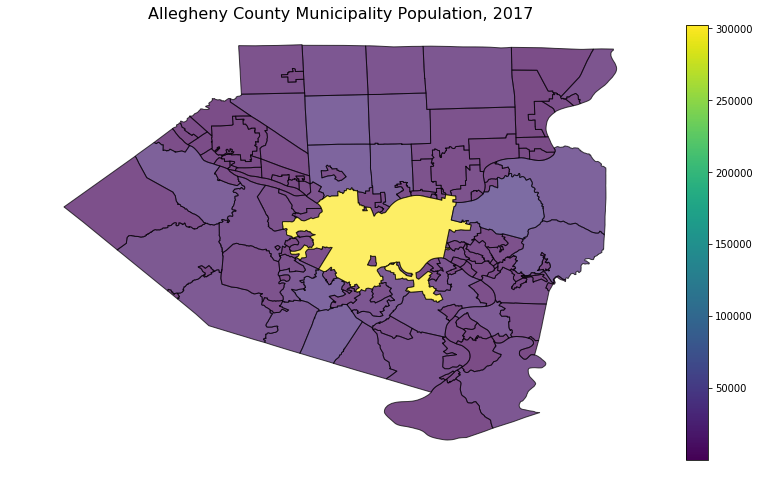

In [232]:
ag_pop.plot(figsize=(15,8), edgecolor='black', column='pop 2017', alpha=0.7,
              legend=True, legend_kwds={'loc': 4})
plt.title('Allegheny County Municipality Population, 2017', size=16)
plt.axis('off');

Since Pittsburgh is such an outlier in terms of population, the log of 'pop 2017' is easier to interpret.

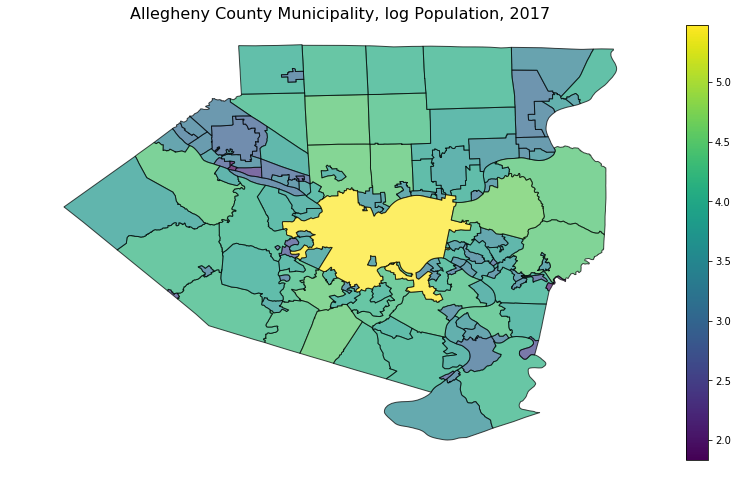

In [233]:
ag_pop['log pop 2017'] = ag_pop['pop 2017'].map(lambda x: np.log10(x))
ag_pop.plot(figsize=(15,8), edgecolor='black', column='log pop 2017', alpha=0.7,
              legend=True, legend_kwds={'loc': 4})
plt.title('Allegheny County Municipality, log Population, 2017', size=16)
plt.axis('off');

### Feature engineering
Using `apply` or `map`, the following features are added to the data:
- 'log officers': log (number of officers)
- 'log pop 2017': log (population)
- 'ppl per officer': population divided / number of officers
- 'officers per 1k': number of officers per 1000 people (num officers / population * 0.001)
- 'log officers per 1k': log (number of officers / population * 0.001 )

In [245]:
ag_pd_dissolve['log officers'] = ag_pd_dissolve['officers'].map(lambda x: np.log10(x))
ag_pd_dissolve['log pop 2017'] = ag_pd_dissolve['pop 2017'].map(lambda x: np.log10(x))
ag_pd_dissolve['ppl per officer'] = ag_pd_dissolve.apply(lambda x: x['pop 2017']/x['officers'], axis=1)
ag_pd_dissolve['officers per 1k'] = ag_pd_dissolve.apply(lambda x: x['officers']/x['pop 2017'], axis=1)
ag_pd_dissolve['log officers per 1k'] = ag_pd_dissolve['officers per 1k'].map(lambda x: np.log10(x))

A geographical plot of 'log officers per 1k' gives a qualitative look at levels of policing compare across the county. Using 'log' instead of the raw numbers to better visualize a data set with some heavy outliers.

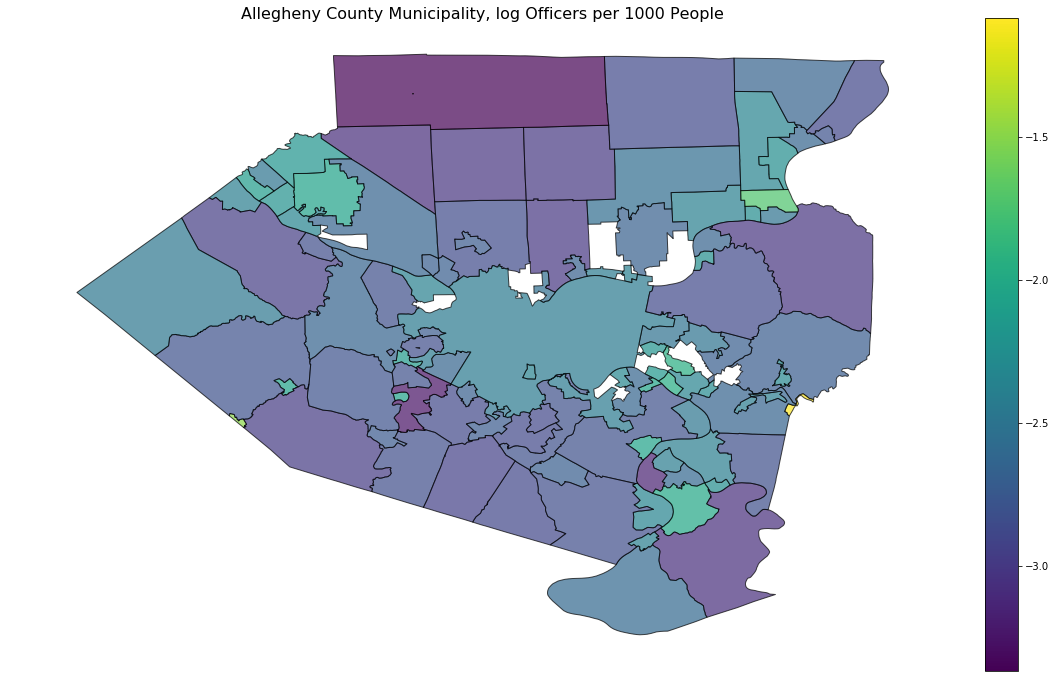

In [242]:
var = 'log officers per 1k'

fig, ax = plt.subplots(1, figsize=(20, 12))
ag_pd_dissolve.plot(ax=ax, edgecolor='black', column=var, alpha=0.7,
              legend=True, legend_kwds={'loc': 4})
plt.title('Allegheny County Municipality, log Officers per 1000 People', size=16)
plt.axis('off');

A scatterplot of the log of population against the log of the number of officers reveals a positive correlation bewteen population size and number of officers, which makes intuitive sense.

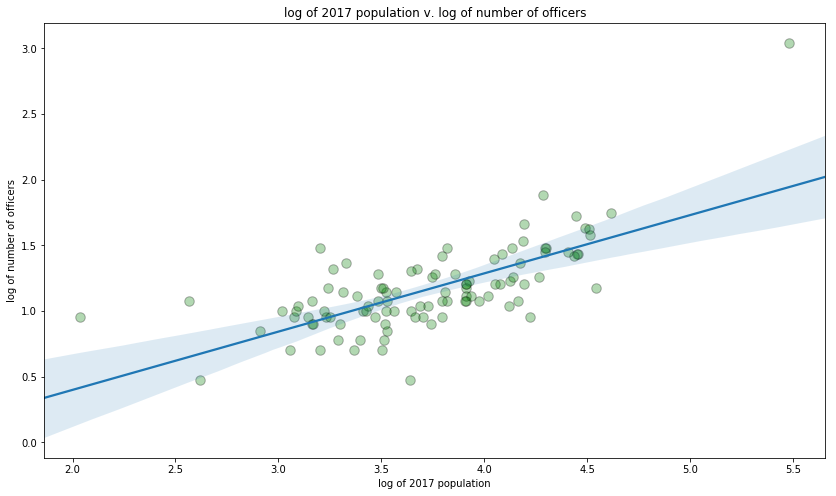

In [246]:
data = ag_pd_dissolve

kwargs = {'alpha':0.3, 'color':'green', 's':90, 'edgecolor':'black'}

fig = plt.figure(figsize=(14,8))

plt.title(s='log of 2017 population v. log of number of officers')
sns.regplot(data=data, x='log pop 2017', y='log officers', scatter_kws=kwargs)
plt.xlabel(('log of 2017 population'))
plt.ylabel(('log of number of officers'));

Population ('log pop 2017') and the ratio of officers to population ('log officers per 1k') appear negatively correlated.

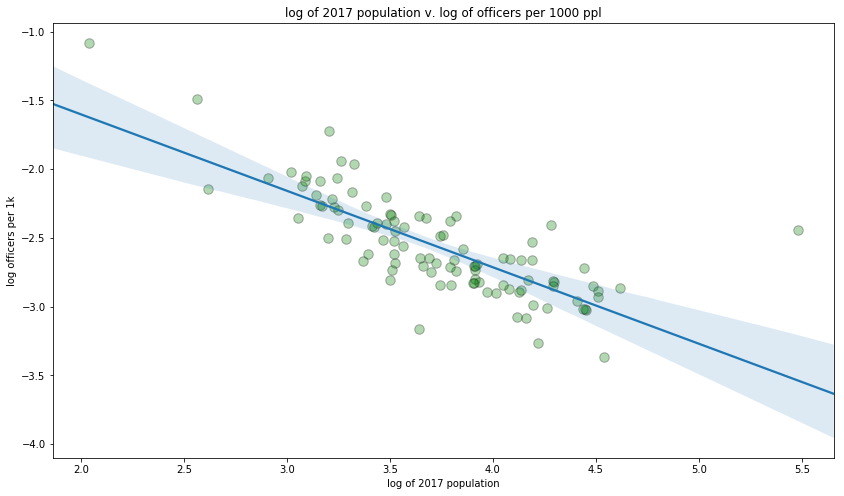

In [248]:
data = ag_pd_dissolve

kwargs = {'alpha':0.3, 'color':'green', 's':90, 'edgecolor':'black'}

fig = plt.figure(figsize=(14,8))

plt.title(s='log of 2017 population v. log of officers per 1000 ppl')
sns.regplot(data=data, x='log pop 2017', y='log officers per 1k', scatter_kws=kwargs)
plt.xlabel(('log of 2017 population'));

Looking at the residual plot, the errors mostly fall within a predictable range except for a handful of notable outliers.

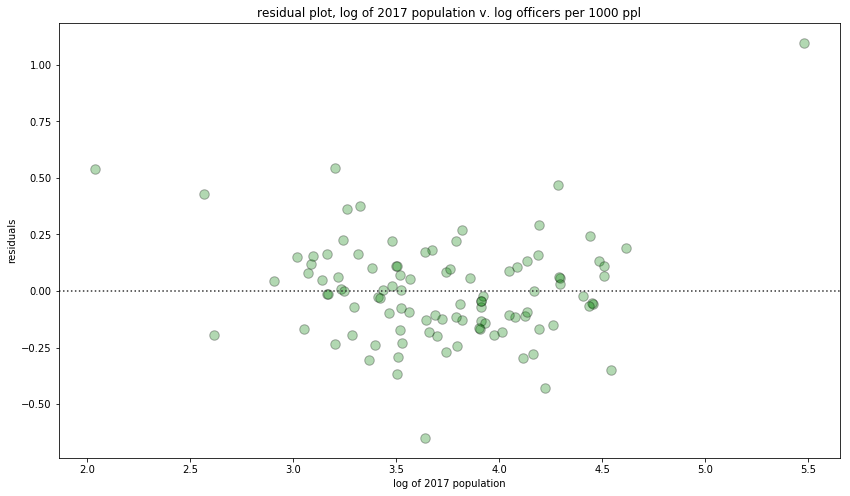

In [264]:
data = ag_pd_dissolve

fig = plt.figure(figsize=(14,8))


plt.title(s='residual plot, log of 2017 population v. log officers per 1000 ppl')
sns.residplot(data=data, x='log pop 2017', y='log officers per 1k', scatter_kws=kwargs)
plt.xlabel(('log of 2017 population'))
plt.ylabel(('residuals'));

We can identify the outliers (and look at the distribution of the error more effectively) by running a simple linear regression.

In [271]:
# assign variables for linear model
data = ag_pd_dissolve
y = data['log officers per 1k']
X = data['log pop 2017']

# model data and calculate residuals
model = sm.OLS(y,X)
results = model.fit()
y_hat = results.predict()
resid = y - y_hat

# add residuals and absolute value of residuals to working dataframe
ag_pd_dissolve['residual'] = resid
ag_pd_dissolve['abs residual'] = ag_pd_dissolve['residual'].map(lambda x: abs(x))

It's now straightforward to find the agencies which deviate most of their expected ratios of police to population.

In [277]:
ag_pd_dissolve[['agency','pop 2017','residual','abs residual']].sort_values('abs residual', ascending=False).head(10)

,agency,pop 2017,residual,abs residual
128,Pittsburgh P.D.,302407,1.314907,1.314907
73,Glassport P.D.,4367,-0.669603,0.669603
71,McKeesport P.D.,19245,0.531176,0.531176
48,Springdale Township P.D.,1596,0.468108,0.468108
47,Brackenridge P.D.,3179,-0.404315,0.404315
104,Scott Township P.D.,16623,-0.375358,0.375358
27,Fawn Township P.D.,2333,-0.361984,0.361984
103,Rosslyn Farms P.D.,415,-0.347612,0.347612
35,Wilkinsburg P.D.,15554,0.342251,0.342251
98,Ingram P.D.,3248,-0.328072,0.328072


Since we are doing all this analysis with a larger eye towards the effects of department consolidation, how do the agencies which cover more than one jurisdiction rank?

In [282]:
ag_pd_dissolve[ag_pd_dissolve['jurisdictions'] > 1][['agency','pop 2017','jurisdictions','residual','abs residual']].sort_values('abs residual', ascending=False).head(10)

,agency,pop 2017,jurisdictions,residual,abs residual
5,Northern Regional P.D.,34800,4,-0.254589,0.254589
1,Crafton P.D.,6246,2,-0.241441,0.241441
6,Ohio Township P.D.,15459,8,0.211811,0.211811
7,Sewickley P.D.,4381,2,0.153868,0.153868
8,White Oak P.D.,8014,2,-0.150602,0.150602
4,North Versailles P.D.,12161,2,0.144524,0.144524
3,Elizabeth Borough P.D.,1984,2,-0.135696,0.135696
0,Carnegie P.D.,8559,2,-0.124841,0.124841
2,East McKeesport P.D.,2646,2,-0.078178,0.078178


## Conclusion and next steps

There is not much to be concluded from this basic analysis of population and policing in and of itself. It's impossible to make reasonable statements about how many police any area needs without considering data on criminal activity in the area or how much of the municipal budget goes to public safety.

For example: Wilkinsburg is ostensibly "overpoliced" in terms of how many officers we would expect it to have given its population. As an anecdotally high crime area, it might make sense to have a larger police force (if we ignore, for the moment, questions about whether more police actually reduce crime). This, in turn, is complicated by its budget problems. A high crime area may have a need for more police, but a more pressing need to spend its money elsewhere. Adding this data into the mix is an obvious next step.

But in the mean time, this rough look at police/population ratios is a good baseline for doing the same research in other metropolitan areas. I will probably start with St. Louis and Baltimore.